# Project 1: Logistic Regression
## This Project gives extra points for the final grade

## **Due 27.11.2025, 16:00**

## Overview

### **Submit your project solution as a group of 2-4 people.**

In this project, you will train a **Logistic Regression** model on a non-linear dataset. The following steps serve as a guide:

### Tasks

1. **Feature Engineering**
   - Since Logistic Regression is a linear classifier, you need to perform feature engineering to make the data linearly separable
   - Consider preprocessing original features
   - Figure out what extra features you should add to the data

2. **Implement Training Loop**
   - Implement the training loop for your Logistic Regression model using **Gradient Descent**
   - Use **BCE Loss** (Binary Cross-Entropy)
   - Incorporate a **regularization** technique to prevent overfitting

3. **Hyperparameter Tuning**
   - Train your model and find good hyperparameters using the **validation set**

4. **Visualization**
   - Visualize the **loss and accuracy curves** of the training process

5. **Testing & Evaluation**
   - Test your trained model on the given **test set**
   - Output the final accuracy rate

### **For full points you need to atleast achieve 73% accuracy on the testing set**

### **NOTE**: 
#### You are not allowed to use sklearn, pytorch or similar Deep Learning frameworks. Numpy is allowed.

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
DATA_PATH = "C:/Users/t00002k9/OneDrive - Trench Group/Desktop/doc/hhu/machine learning/project/dataset.csv"

df = pd.read_csv(DATA_PATH)
X = df[["x1", "x2"]].values.astype(float)
y = df["y"].values.astype(int)
print(f"Dataset shape: {X.shape}")
print(f"Classes: {np.unique(y)}")
print(f"\nFirst 5 samples:")
print(df.head())

train_split = int(len(X) * 0.7)      
val_split = int(len(X) * 0.85)       

x_train = X[:train_split]              
x_val = X[train_split:val_split]    
x_test = X[val_split:]  
y_train = y[:train_split]              
y_val = y[train_split:val_split]    
y_test = y[val_split:]
print(f"\nTrain set: {x_train.shape[0]} samples")
print(f"Validation set: {x_val.shape[0]} samples")
print(f"Test set: {x_test.shape[0]} samples")


Dataset shape: (1000, 2)
Classes: [0 1]

First 5 samples:
          x1        x2  y
0   9.492170  0.272589  0
1  16.829156 -0.787517  0
2   0.175471  0.412100  1
3  80.509510 -0.688343  1
4  68.193111  1.447592  0

Train set: 700 samples
Validation set: 150 samples
Test set: 150 samples


In [75]:
def visualize(X, y, title="Data Visualization"):
    cls0 = y == 0
    cls1 = y == 1
    plt.figure()
    plt.scatter(X[cls0, 0], X[cls0, 1], label="y=0", alpha=0.7)
    plt.scatter(X[cls1, 0], X[cls1, 1], label="y=1", alpha=0.7)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

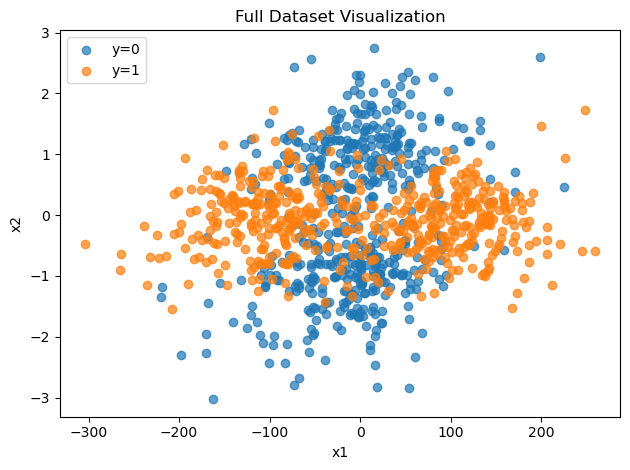

In [76]:
visualize(X, y, title="Full Dataset Visualization")

**(1) Feature Engineering: 2 Points**

Since logistic regression is a linear classifier, one can not expect to perform very well on data that is not linearly seperable. 

Try to figure out how to transform the data, e.g preprocessing original features and adding new features, such that the data becomes linearly seperable.

In [77]:
#Feature Engineering
def add_features(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    features = [x1, x2, x1**2, x2**2, x1 * x2]
    return np.column_stack(features)

def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

X_poly = add_features(X)
X_poly = normalize(X_poly)

# Update splits
x_train = X_poly[:train_split]
x_val = X_poly[train_split:val_split]
x_test = X_poly[val_split:]


**(2) Training Logic: 2 Points**

Implement the training logic by finding the best model parameters for logistic regression. Since we have only 2 classes, BCE Loss is a proper loss function. 

Consider implementing regularization to avoid overfitting.

The training loop should take the training set (- and validation set for hyperparameter tuning later), aswell as the hyperparameters, initialize weights and do gradient descent. 

You should track the losses and accuracies throughout the epochs for later visualization.

In [78]:
# Logistic Regression Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, W, b):
    return sigmoid(X @ W + b)

def bce_loss(W, b, X, y, lam=0.0):
    m = len(y)
    p = predict(X, W, b)
    loss = -np.mean(y * np.log(p + 1e-8) + (1 - y) * np.log(1 - p + 1e-8))
    reg = lam * np.sum(W**2) / (2 * m)
    return loss + reg

def grad_bce_with_l2(W, b, X, y, lam=0.0):
    m = len(y)
    p = predict(X, W, b)
    error = p - y
    dW = (X.T @ error) / m + lam * W / m
    db = np.mean(error)
    return dW, db

def accuracy(y, p):
    return np.mean((p >= 0.5) == y)


In [79]:
# Training Loop
def train_model(X_tr, y_tr, X_val, y_val, lr=0.1, lam=0.0, epochs=500):
    W = np.zeros(X_tr.shape[1])
    b = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Compute gradients
        dW, db = grad_bce_with_l2(W, b, X_tr, y_tr, lam)
        # Update weights
        W -= lr * dW
        b -= lr * db

        # Track metrics
        train_losses.append(bce_loss(W, b, X_tr, y_tr, lam))
        val_losses.append(bce_loss(W, b, X_val, y_val, lam))
        train_accs.append(accuracy(y_tr, predict(X_tr, W, b)))
        val_accs.append(accuracy(y_val, predict(X_val, W, b)))

    return W, b, train_losses, val_losses, train_accs, val_accs


**(3) Hyperparameter tuning: 0.5 Points**

Your logistic regression model has hyperparameters, e.g. learning rate/regularization lambda, and since there are no  best hyperparameters in general, one has to find them by grid searching through them for the specific model.

Implement the grid search function by going through all possible defined parameters, train the model and evaluate on validation set. 

Save the best hyperparameters and return them.

In [80]:
# Hyperparameter Tuning

lr_list = [0.01, 0.05, 0.1]
lambda_list = [0.0, 0.01, 0.1]

def grid_search(X_tr, y_tr, X_val, y_val, lr_list, lambda_list, epochs=500):
    best_acc = 0
    best_lr, best_lambda = None, None
    for lr in lr_list:
        for lam in lambda_list:
            W, b, _, _, _, val_accs = train_model(X_tr, y_tr, X_val, y_val, lr, lam, epochs)
            if val_accs[-1] > best_acc:
                best_acc = val_accs[-1]
                best_lr, best_lambda = lr, lam
    return best_lr, best_lambda


**(4) Training and (5) Testing: 0.5 Points**

- Use grid search to find the best hyperparameters
- train your model with found hyperparameters
- visualize loss and accuracy curves
- test your model on the testing set

In [81]:
#Train with best hyperparameters
best_lr, best_lambda = grid_search(x_train, y_train, x_val, y_val, lr_list, lambda_list,epochs = 500)
print(f"Best hyperparameters: lr={best_lr}, lam={best_lambda}")

W, b, train_losses, val_losses, train_accs, val_accs = train_model(x_train, y_train, x_val, y_val, best_lr, best_lambda)


Best hyperparameters: lr=0.05, lam=0.0


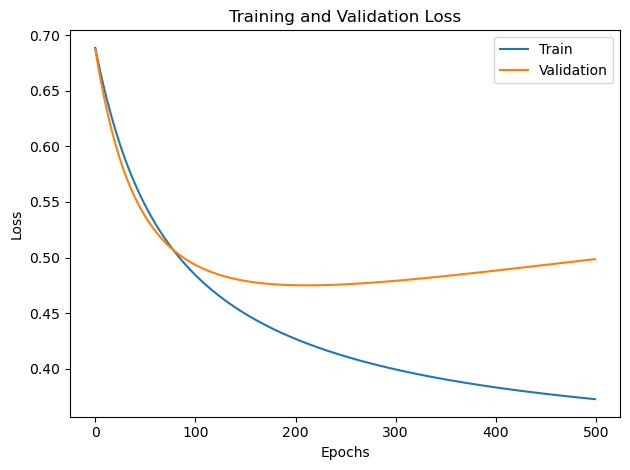

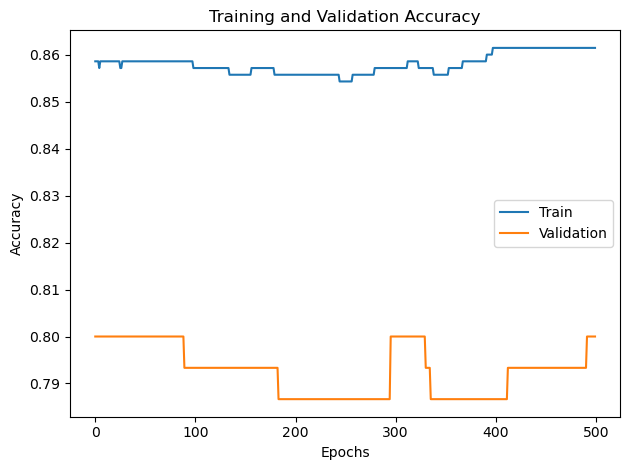

In [82]:
# visualize loss and accuracy curves
def plot_curves(train_values, val_values, ylabel, title):
    plt.figure()
    plt.plot(train_values, label="Train")
    plt.plot(val_values, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_curves(train_losses, val_losses, ylabel="Loss", title="Training and Validation Loss")
plot_curves(train_accs, val_accs, ylabel="Accuracy", title="Training and Validation Accuracy")

In [83]:
# TODO: (5) test your model on the test set

In [84]:
# Test Evaluation
test_preds = predict(x_test, W, b)
test_acc = accuracy(y_test, test_preds)

# Print final test accuracy
print(f"Final Test Accuracy: {test_acc * 100:.2f}%")



Final Test Accuracy: 75.33%
